In [1]:
import os, glob
# os.getcwd()

os.chdir('/vera/ptmp/gc/uchadaya/ContrastiveLearning/simclr-gas/')

from scripts.data import datasets
import yaml
import config as c

import torch
from torchvision.transforms import transforms
from scripts.data.augmentations import *

from astropy.io import fits
import matplotlib.pylab as plt
from matplotlib import colors, cm

plt.rcParams['font.size'] = 12

In [2]:
data_params = yaml.safe_load(open('params.yaml'))['data']
data_params

{'VALID_RANGE': ['None'],
 'DATASET': 'SingleStretchDataset',
 'FILTERS': ['0.5-5.0'],
 'IMAGE_SIZE': 128,
 'NUM_WORKERS': 16}

In [3]:
c.dataset_raw_path
# this is used to make self._image_path in the extractor
# this is opened by the datasets.FitsDataset object as:
# hdu = fits.open(image_path)[filter].data
# in my case there's only one filter
# then the _stretch function maps the values to (0,1)
# then these are scaled linearly to (0, 255) for easy compatibility with PILImage later
# I'm wondering if this is strictly necessary

'./dataset_raw/'

In [4]:
data1 = datasets.SingleStretchDataset(image_file='dataset_raw/Xray-TNG-Cluster/label.csv')

In [7]:
data1.image_paths

0       dataset_raw/Xray-TNG-Cluster/images/snap91_hal...
1       dataset_raw/Xray-TNG-Cluster/images/snap72_hal...
2       dataset_raw/Xray-TNG-Cluster/images/snap78_hal...
3       dataset_raw/Xray-TNG-Cluster/images/snap91_hal...
4       dataset_raw/Xray-TNG-Cluster/images/snap99_hal...
                              ...                        
7963    dataset_raw/Xray-TNG-Cluster/images/snap99_hal...
7964    dataset_raw/Xray-TNG-Cluster/images/snap99_hal...
7965    dataset_raw/Xray-TNG-Cluster/images/snap84_hal...
7966    dataset_raw/Xray-TNG-Cluster/images/snap50_hal...
7967    dataset_raw/Xray-TNG-Cluster/images/snap67_hal...
Name: image_path, Length: 7968, dtype: object

In [8]:
with fits.open(data1.df['image_path'][0]) as f:
    img = f['0.5-5.0'].data

In [5]:
params = yaml.safe_load(open('params.yaml'))['train_clr']['AUGMENTATION_PARAMS']
params

{'ROTATION': 15,
 'TRANSLATE': 0.25,
 'SCALE': 1.1,
 'FLIP': True,
 'GAUSSIAN_BLUR_SIGMA': [0.0001, 0.1],
 'NOISE_STD': [0.01, 0.08],
 'CLIP_MIN': 0.2}

0.19037681397308137
0.05729546397418439
0.2
0.2
0.2


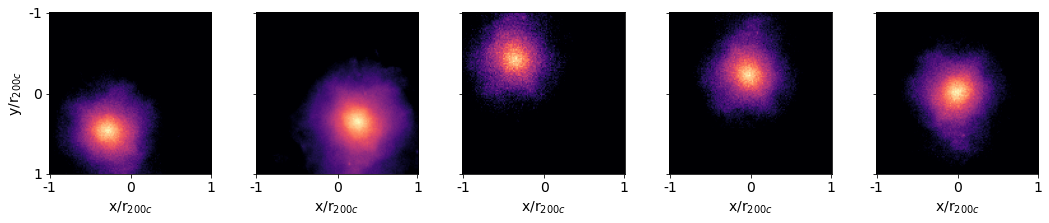

In [29]:
im = data1._get_single_image_path(data1.df['image_path'][5]) 
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(15,3))

for i in range(5):
#     params['CLIP_DELTA'] = (i+1)/5 
    data3 = datasets.SimClrDataset(image_file='dataset_raw/Xray-TNG-Cluster/label.csv', augmentation=SimCLRAugmentation(params))
    tensor_im = torch.tensor(im[:,:,0])
    clip_im = data3.transform(tensor_im)
    imj = ax[i].imshow(clip_im[0,:,:], cmap=cm.magma)
#     ax[i].set_title('CLIP_MIN = %0.1f' % params['CLIP_MIN'])

for a in ax:
    a.set_xlabel(r'x/r$_{200c}$', fontsize=14, family='sans-serif')
    a.set_xticks([0, 64, 127])
    a.set_xticklabels([-1, 0, 1], fontsize=14, family='sans-serif')
ax[0].set_ylabel(r'y/r$_{200c}$', fontsize=14, family='sans-serif')
ax[0].set_yticks([0, 64, 127])
ax[0].set_yticklabels([-1, 0, 1], fontsize=14, family='sans-serif')
plt.tight_layout()
plt.savefig('temp/augmentations.png', dpi=192)

0.2
0.2
0.002751761633823735
0.05556218160337767
0.10896633589099713


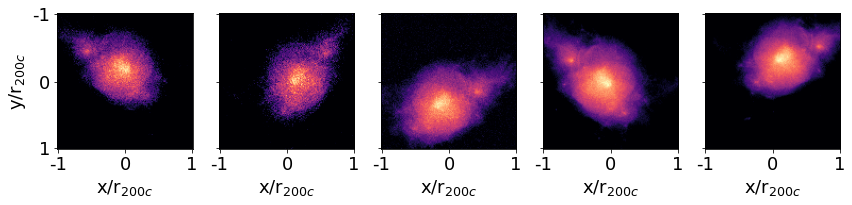

In [17]:
im = data1._get_single_image_path(data1.df['image_path'][8]) 
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(15,3))

for i in range(5):
#     params['CLIP_DELTA'] = (i+1)/5 
    data3 = datasets.SimClrDataset(image_file='dataset_raw/Xray-TNG-Cluster/label.csv', augmentation=SimCLRAugmentation(params))
    tensor_im = torch.tensor(im[:,:,0])
    clip_im = data3.transform(tensor_im)
    imj = ax[i].imshow(clip_im[0,:,:], cmap=cm.magma)
#     ax[i].set_title('CLIP_MIN = %0.1f' % params['CLIP_MIN'])

for a in ax:
    a.set_xlabel(r'x/r$_{200c}$', fontsize=18, family='sans-serif')
    a.set_xticks([0, 64, 127])
    a.set_xticklabels([-1, 0, 1], fontsize=18, family='sans-serif')
ax[0].set_ylabel(r'y/r$_{200c}$', fontsize=18, family='sans-serif')
ax[0].set_yticks([0, 64, 127])
ax[0].set_yticklabels([-1, 0, 1], fontsize=18, family='sans-serif')
plt.tight_layout(rect=[0,0,0.8,1],h_pad=-1)
plt.savefig('temp/augmentations3.png', dpi=192)

Ok! The clipping applies in a space between 0 and 1 
So I should define SingleStretchDataset to have a fixed dynamic range, e.g. 5
Then clip delta is in units of 1/5. I.e. clip_delta = 1 keeps everything above 0.8, 2 above 0.6, ... 5 keeps everything.  

In [30]:
data1.df

,d_log_sfr,d_bh_kinj_cum,d_bh_tinj_cum,d_bh_einj_cum,d_bh_accr,d_bh_mass,d_gas_mass,d_stellar_mass,sublink_tmerge_major,sublink_last_major_snap,...,bh_accr,halo_num,snapshot_id,subhalo_id,projection,image_path,log_sfr,bh_tinj_cum,bh_kinj_cum,bh_einj_cum
0,-0.772655,0.154534,0.139190,0.123813,-0.287852,0.109836,0.002300,0.052371,0.854942,85,...,1.076560e+06,19213769.0,91.0,10666596.0,2,dataset_raw/Xray-TNG-Cluster/images/snap91_hal...,-1.758264,5.127102e+08,2.995399e+08,8.122501e+08
1,1.293827,0.339670,0.364311,0.343829,0.816039,0.340819,-0.023492,0.086491,0.926894,65,...,1.773365e+07,18294187.0,72.0,11305251.0,0,dataset_raw/Xray-TNG-Cluster/images/snap72_hal...,0.714415,5.529482e+08,3.255365e+08,8.784847e+08
2,1.580152,-0.252477,-0.304617,-0.308297,-0.525928,-0.309102,-0.041075,-0.212340,3.533269,51,...,1.066308e+06,7664173.0,78.0,4569324.0,0,dataset_raw/Xray-TNG-Cluster/images/snap78_hal...,0.138561,3.422164e+08,2.041555e+08,5.463718e+08
3,0.465282,0.155821,0.122632,0.108752,-0.272694,0.096890,0.008566,-0.032269,0.463524,88,...,1.081974e+06,18745186.0,91.0,10403552.0,2,dataset_raw/Xray-TNG-Cluster/images/snap91_hal...,-0.557141,5.491208e+08,3.224591e+08,8.715799e+08
4,4.204510,0.492602,0.235078,0.321276,3.002621,0.243673,0.068946,0.149956,0.939925,93,...,9.331916e+09,3656685.0,99.0,1912908.0,2,dataset_raw/Xray-TNG-Cluster/images/snap99_hal...,2.725728,2.694848e+09,2.512587e+09,5.207435e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7963,-0.538152,0.255195,0.227312,0.209706,0.201103,0.211723,0.035495,-0.014975,1.060276,92,...,4.626654e+06,17352215.0,99.0,9266690.0,0,dataset_raw/Xray-TNG-Cluster/images/snap99_hal...,-1.860018,9.852491e+08,5.400196e+08,1.525269e+09
7964,-0.420870,0.225288,0.276945,0.242312,-0.138664,0.251708,0.029562,-0.003771,4.188079,70,...,2.635002e+06,16460046.0,99.0,8771038.0,2,dataset_raw/Xray-TNG-Cluster/images/snap99_hal...,-1.860018,1.287495e+09,6.337295e+08,1.921225e+09
7965,-0.775368,0.344720,0.246122,0.265051,-0.016677,0.238324,0.078734,0.192667,0.000000,84,...,3.486020e+06,8179091.0,84.0,4697952.0,1,dataset_raw/Xray-TNG-Cluster/images/snap84_hal...,-2.203459,1.185649e+09,8.132495e+08,1.998899e+09
7966,0.305431,-0.066827,-0.292252,-0.212642,-0.728203,-0.273079,-0.080360,0.024818,5.265350,9,...,3.868093e+05,9062442.0,50.0,6623940.0,2,dataset_raw/Xray-TNG-Cluster/images/snap50_hal...,-0.662602,1.822677e+08,1.772297e+08,3.594974e+08


In [31]:
model_params = yaml.safe_load(open('params.yaml'))['model']
model_params

{'CLAMP': 1.0,
 'NUM_COUPLING_LAYERS': 12,
 'NUM_COND_NODES': 128,
 'NUM_HIDDEN_NODES': 128,
 'NUM_HIDDEN_LAYERS': 2,
 'DROPOUT': 0.0,
 'BATCH_NORM': False,
 'NUM_HIDDEN_NODES_COND': 128,
 'NUM_HIDDEN_LAYERS_COND': 2,
 'DROPOUT_COND': 0.0,
 'BATCH_NORM_COND': False,
 'NUM_HIDDEN_NODES_MLP': 128,
 'NUM_HIDDEN_LAYERS_MLP': 2,
 'DROPOUT_MLP': 0.0,
 'BATCH_NORM_MLP': False,
 'RESNET_DEPTH': 16,
 'RESNET_WIDTH': 2,
 'RESNET_DROPOUT': 0.3,
 'RESNET_REPRESENTATION_DIM': 256,
 'RESNET_REPRESENTATION_DEPTH': 2,
 'RESNET_PROJECTION_DIM': 256,
 'RESNET_PROJECTION_DEPTH': 2,
 'RESNET_NUM_CHANNELS': 1,
 'RESNET_ROTATION_EQUIVARIANCE': 8,
 'RESNET_ROTATION_RESTRICTION': 0,
 'RESNET_REFLECTION_EQUIVARIANCE': True,
 'RESNET_INITIAL_STRIDE': 2,
 'PATIENCE': 15}